In [1]:
# to be run in the root github directory
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=8.5)
suppressMessages(library(rtracklayer)); suppressMessages(library(DESeq2))
suppressMessages(library(GGally))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

ggplot2::theme_set(ggplot2::theme_bw())  ## (this just globally sets the ggplot2 theme to theme_bw) 


source('../hal_scripts/narrowPeakFunctions.R')

In [2]:
library("BiocParallel")
register(MulticoreParam(round(parallel::detectCores()/2)))

# Load RSE pseudobulk object & clean
- drop `Cluster2` cell types not in all 3 species

In [3]:
########################################################################
## load in ranged summarized experiment file and create DESeq2 object ##
orthPeakRSE_fn = file.path(PROJDIR, 'rdas', 'orthologPeak_pseudoBulkRSE.rds')
orthPeakRSE = readRDS(file = orthPeakRSE_fn)
orthPeakRSE

class: RangedSummarizedExperiment 
dim: 271225 81 
metadata(0):
assays(1): counts
rownames(271225): f1 f2 ... f271224 f271225
rowData names(2): idx name
colnames(81): 06_0615.CAUD#Astro 06_0615.CAUD#Interneuron ...
  CEMBA180820_5E#OPC CEMBA180820_5E#VLMC
colData names(19): TSSEnrichment ReadsInTSS ... Clusters2 log10nFrags

In [4]:
head(colData(orthPeakRSE))

DataFrame with 6 rows and 19 columns
                         TSSEnrichment ReadsInTSS ReadsInPromoter
                             <numeric>  <numeric>       <numeric>
06_0615.CAUD#Astro               9.629     3228.5          3682.5
06_0615.CAUD#Interneuron         7.645       3342            4108
06_0615.CAUD#Microglia          8.9705     1568.5          1886.5
06_0615.CAUD#MSN_D1              7.994       3856            4633
06_0615.CAUD#MSN_D2              8.299       3717            4447
06_0615.CAUD#MSN_UNK1            8.851       6485            7762
                             PromoterRatio    PassQC   NucleosomeRatio
                                 <numeric> <numeric>         <numeric>
06_0615.CAUD#Astro       0.168464900973469         1  1.12510423720918
06_0615.CAUD#Interneuron  0.11744145403705         1  1.22183216315614
06_0615.CAUD#Microglia   0.144328552492024         1 0.923052773199338
06_0615.CAUD#MSN_D1      0.132552215995925         1  1.30344023323615
06_0615.C

In [5]:
tt<- with(colData(orthPeakRSE), table(Clusters2, Species))
tt

             Species
Clusters2     hg38 mm10 rheMac10
  Astro          3    4        1
  Interneuron    3    4        1
  Microglia      3    4        1
  MSN_D1         3    4        1
  MSN_D2         3    4        1
  MSN_UNK1       3    0        1
  MSN_UNK2       3    4        0
  Mural          3    4        0
  Oligo          3    4        1
  OPC            3    4        1
  VLMC           3    4        0

In [6]:
keepClusters = rownames(tt)[apply(tt, 1, function(x) all(x > 0))]
keepClusters          

[1] "Astro"       "Interneuron" "Microglia"   "MSN_D1"      "MSN_D2"     
[6] "Oligo"       "OPC"

In [7]:
orthPeakRSE = orthPeakRSE[, colData(orthPeakRSE)$Clusters2 %in% keepClusters]

# Create DESeq2 object & visualize pseudo bulk data

In [8]:
colData(orthPeakRSE)$TSSEnrichment.centered = 
(colData(orthPeakRSE)$TSSEnrichment - mean(colData(orthPeakRSE)$TSSEnrichment))/sd(colData(orthPeakRSE)$TSSEnrichment)

colData(orthPeakRSE)$log10nFrags.centered = 
(colData(orthPeakRSE)$log10nFrags - mean(colData(orthPeakRSE)$log10nFrags))/sd(colData(orthPeakRSE)$log10nFrags)

dds <- DESeqDataSet(orthPeakRSE, design = ~ Clusters2 + Species + Species:Clusters2 +
                    TSSEnrichment.centered + log10nFrags.centered)

converting counts to integer mode

Warning message in DESeqDataSet(orthPeakRSE, design = ~Clusters2 + Species + Species:Clusters2 + :
“some variables in design formula are characters, converting to factors”


In [9]:
vsd <- vst(dds, blind=FALSE)

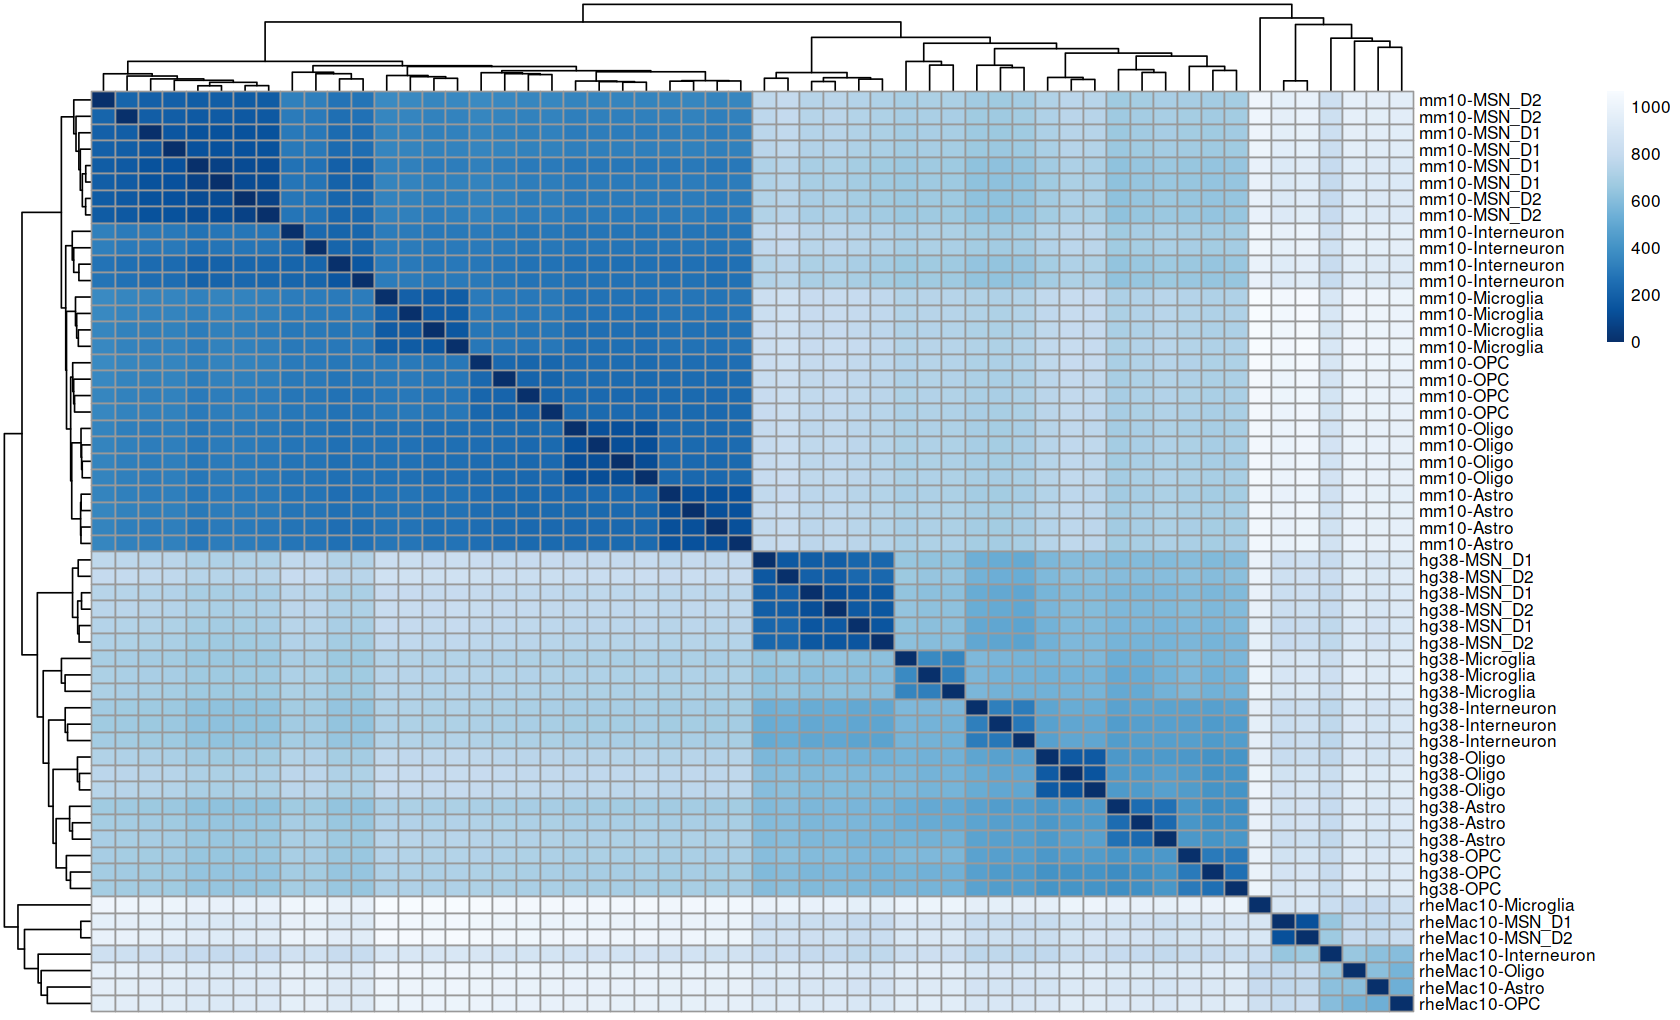

In [10]:
library("RColorBrewer")
library("pheatmap")
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$Species, vsd$Clusters2, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [11]:
pca <- prcomp(t(assay(vsd)))
eigs <- pca$sdev^2
percentVar <- round(eigs/sum(eigs) * 100)

# Create data frame with metadata and PC values for input to ggplot
pcaData <- cbind(as.data.frame(colData(orthPeakRSE)), pca$x)

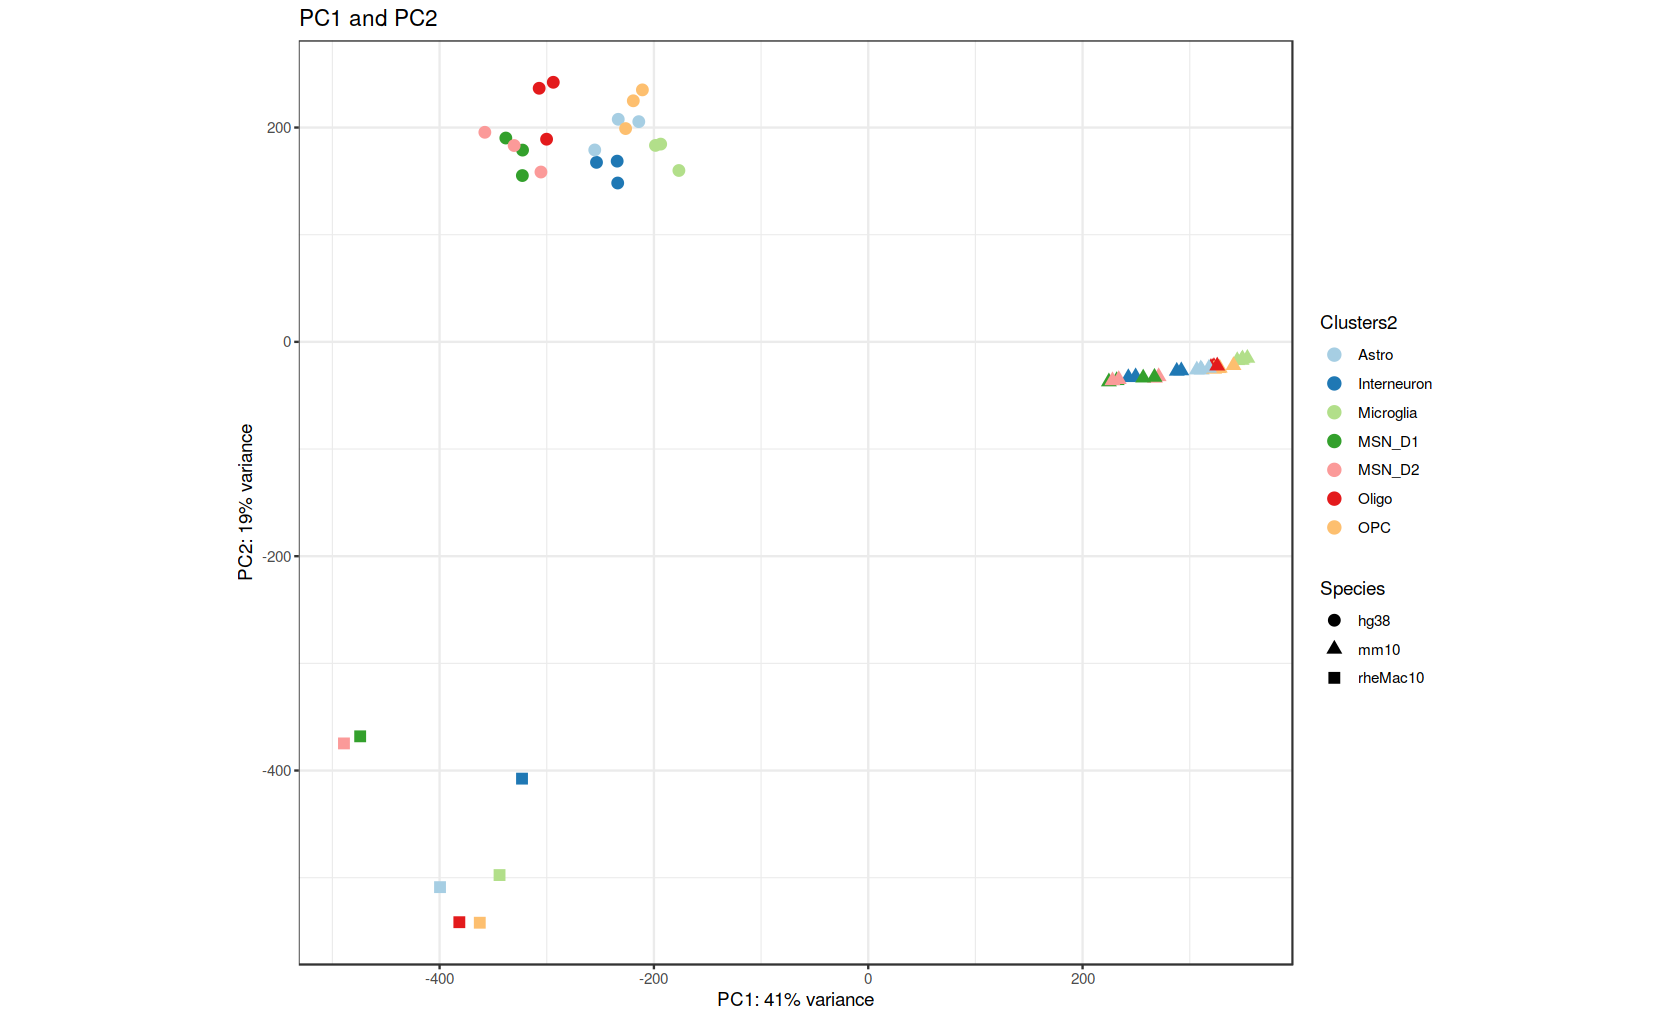

In [12]:
ggplot(pcaData, aes(PC1, PC2, color=Clusters2, shape=Species)) +
  geom_point(size=3) + scale_color_brewer(palette = 'Paired') + 
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() + ggtitle('PC1 and PC2')

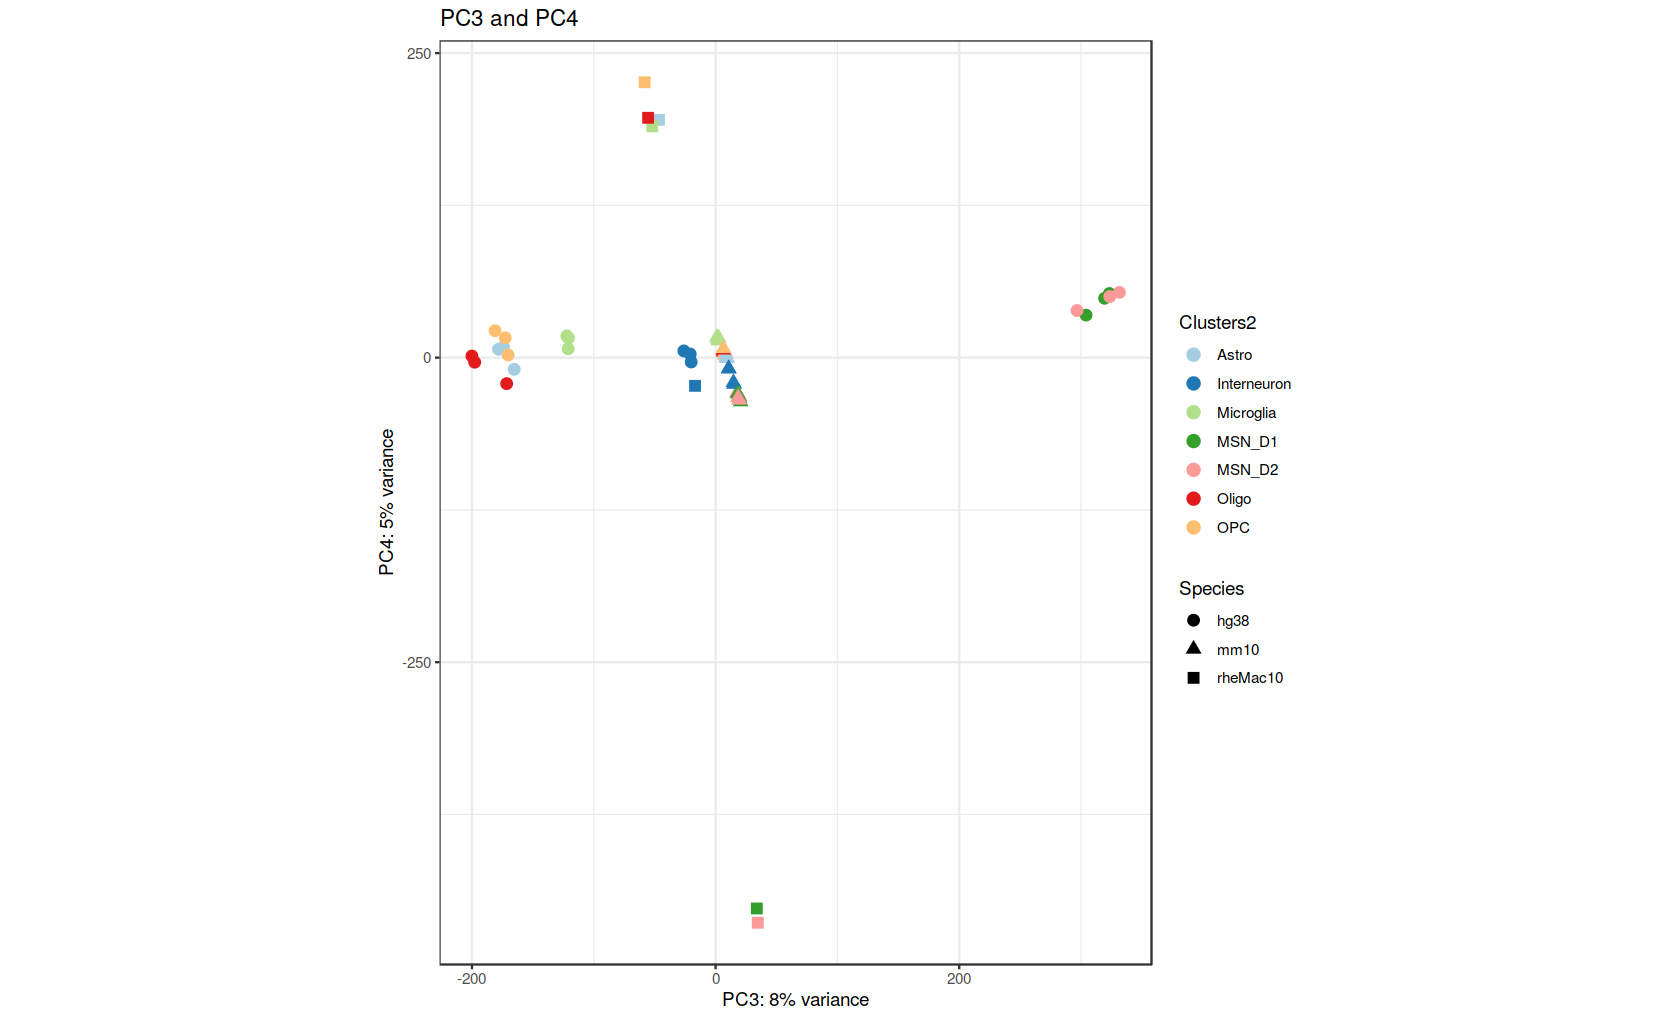

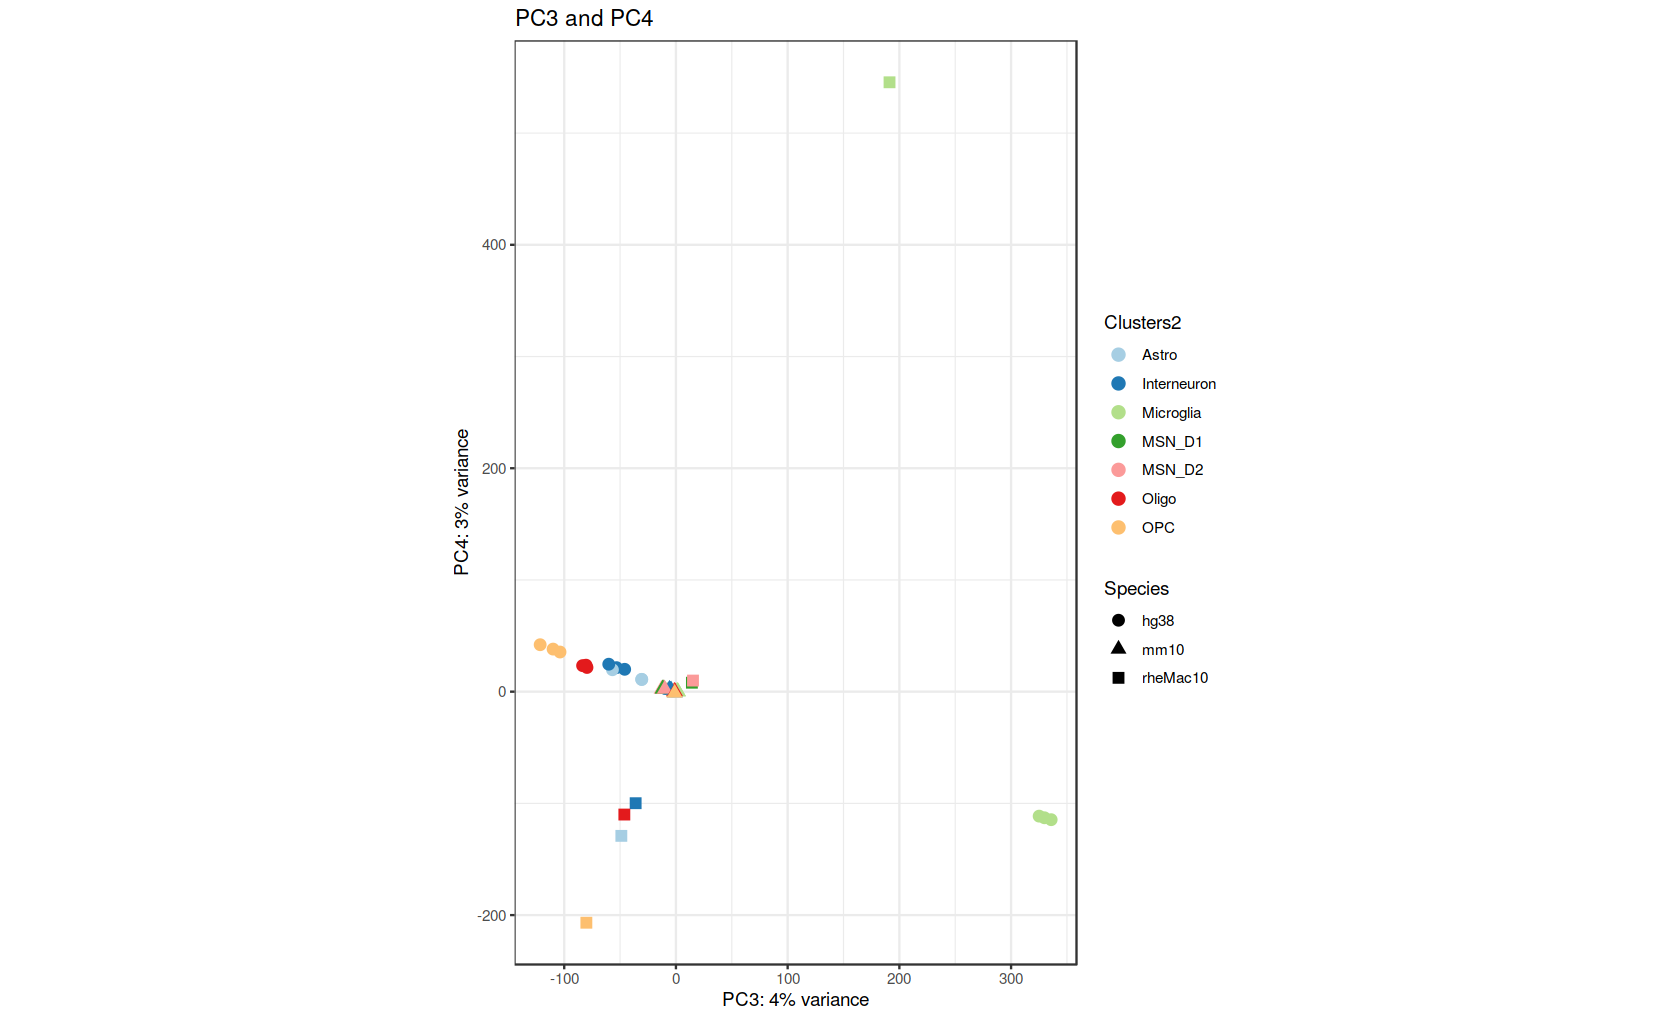

In [18]:
ggplot(pcaData, aes(PC3, PC4, color=Clusters2, shape=Species)) +
  geom_point(size=3) + scale_color_brewer(palette = 'Paired') + 
  xlab(paste0("PC3: ",percentVar[3],"% variance")) +
  ylab(paste0("PC4: ",percentVar[4],"% variance")) + 
  coord_fixed() + ggtitle('PC3 and PC4')

ggplot(pcaData, aes(PC5, PC6, color=Clusters2, shape=Species)) +
  geom_point(size=3) + scale_color_brewer(palette = 'Paired') + 
  xlab(paste0("PC3: ",percentVar[5],"% variance")) +
  ylab(paste0("PC4: ",percentVar[6],"% variance")) + 
  coord_fixed() + ggtitle('PC3 and PC4')

In [14]:
names(pcaData)

[1] "TSSEnrichment"          "ReadsInTSS"             "ReadsInPromoter"       
 [4] "PromoterRatio"          "PassQC"                 "NucleosomeRatio"       
 [7] "nMultiFrags"            "nMonoFrags"             "nFrags"                
[10] "nDiFrags"               "DoubletScore"           "DoubletEnrichment"     
[13] "ReadsInPeaks"           "FRIP"                   "nCells"                
[16] "Species"                "Sample"                 "Clusters2"             
[19] "log10nFrags"            "TSSEnrichment.centered" "log10nFrags.centered"  
[22] "PC1"                    "PC2"                    "PC3"                   
[25] "PC4"                    "PC5"                    "PC6"                   
[28] "PC7"                    "PC8"                    "PC9"                   
[31] "PC10"                   "PC11"                   "PC12"                  
[34] "PC13"                   "PC14"                   "PC15"                  
[37] "PC16"                   "PC17"                   "PC18"                  
[40] "PC19"                   "PC20"                   "PC21"                  
[43] "PC22"                   "PC23"                   "PC24"                  
[46] "PC25"                   "PC26"                   "PC27"                  
[49] "PC28"                   "PC29"                   "PC30"                  
[52] "PC31"                   "PC32"                   "PC33"                  
[55] "PC34"                   "PC35"                   "PC36"                  
[58] "PC37"                   "PC38"                   "PC39"                  
[61] "PC40"                   "PC41"                   "PC42"                  
[64] "PC43"                   "PC44"                   "PC45"                  
[67] "PC46"                   "PC47"                   "PC48"                  
[70] "PC49"                   "PC50"                   "PC51"                  
[73] "PC52"                   "PC53"                   "PC54"                  
[76] "PC55"                   "PC56"

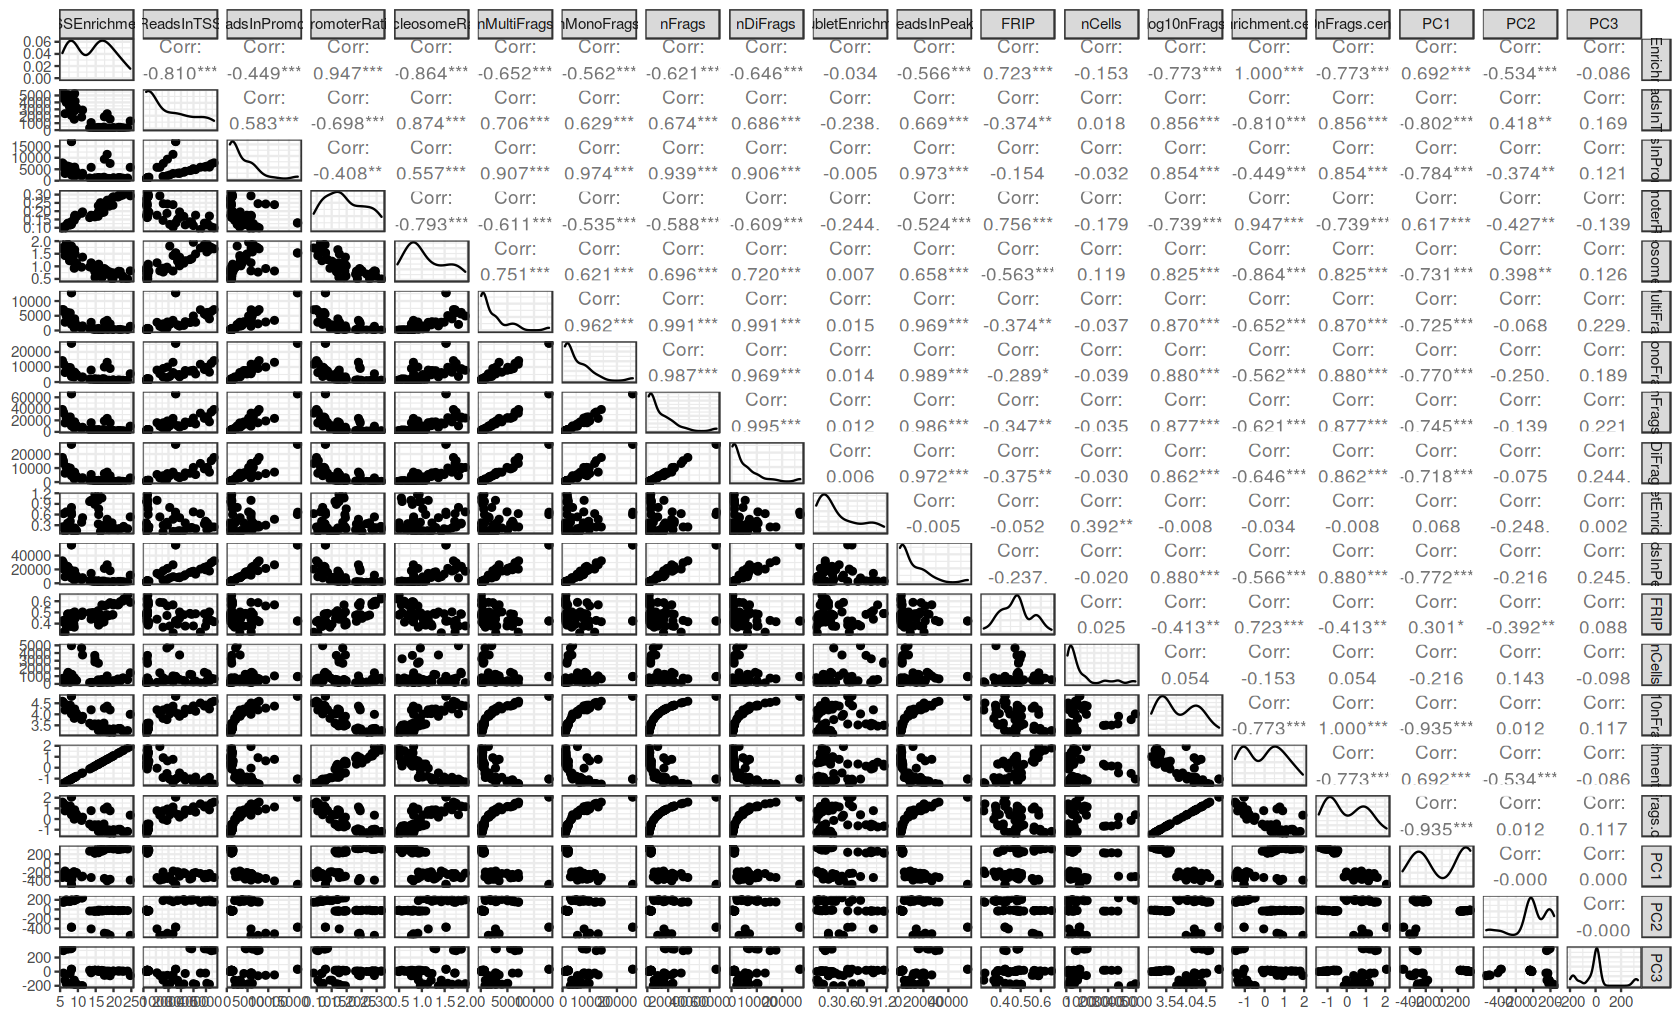

In [15]:
pcaData %>% 
select(-c('Clusters2','Species', 'Sample','PassQC', 'DoubletScore',paste0('PC',4:56) )) %>% 
ggpairs()